# 1. root-finding
求解 $f(x^*)=x^*$问题

## 1.1 使用 不动点迭代法 实现 后向欧拉法
如果系统是稳定的，只要不断地模拟，则会收敛到某个平衡点。Banach不动点定理。

仍然是单摆问题

### 动力学方程
根据牛顿第二定律，单摆的运动方程为：
$$\ddot{\theta} = -\frac{g}{l}\sin(\theta)$$

其中：
- $\theta$：摆角（弧度）
- $\dot{\theta}$：角速度
- $\ddot{\theta}$：角加速度
- $g$：重力加速度（9.81 m/s²）
- $l$：摆长（1.0 m）

### 状态空间表示
定义状态向量 $\mathbf{x} = [\theta, \dot{\theta}]^T$，则系统的状态空间方程为：
$$\dot{\mathbf{x}} = \begin{bmatrix} \dot{\theta} \\ -\frac{g}{l}\sin(\theta) \end{bmatrix} = f(\mathbf{x})$$

我们想要已知初始状态，计算任意时刻单摆的状态，则需要求解这个OED。


In [1]:
# 导入必要的库
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jit
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'SimHei'


# 设置JAX随机种子
key = jax.random.PRNGKey(42)

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jacfwd, jit
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'SimHei'

key = jax.random.PRNGKey(42)
@jit  # 被 @jit 修饰的函数在第一次调用时会被编译，之后的调用会直接运行已编译的高效代码。
def pendulum_dynamics(x, l=1, g=9.81):
    '''
        定义单摆动力学
        输入：
            x: 状态向量 [theta, theta_dot]
            l: 摆长 default=1
            g: 重力加速度 default=9.81
        输出：
            x_dot: 状态变化量 [theta_dot, theta_ddot]
    '''
    theta, theta_dot = x
    theta_ddot = -g/l*jnp.sin(theta)
    x_dot = jnp.array([theta_dot, theta_ddot])
    return x_dot



后向欧拉法（Backward Euler Method）在不动点迭代中的实现如下：对于给定的初值 $x_0$，每一步通过迭代公式

不断更新 $x_{n+1}$，直到收敛到某个误差容限（tol）或达到最大迭代次数（max_iter）。由于 $x_{n+1}$ 出现在等式两侧，需要在每一步通过内层不动点迭代求解 $x_{n+1}$。每次迭代记录误差 $\|x_0 + h f(x_{n+1}) - x_{n+1}\|$，用于判断收敛性。这种实现方式适用于隐式方程的数值求解，具有更好的稳定性。

In [4]:
def BEM_step(func, x0, h, tol=1e-6):
    '''
        BEM (Backwards Euler Method) 步进函数
        输入：
            func: 动力学函数
            x0: 当前状态
            h: 时间步长
            tol: 容忍误差 default=1e-6
        输出：
            x_next: 下一状态
    '''
    err = jnp.inf
    x_next = x0
    while err > tol:
        x_next = x0 + h * func(x_next)
        err = jnp.linalg.norm(x0 + h * func(x_next) - x_next)
    return x_next

def BEM_simulation(func, x0, h, steps):
    '''
        BEM 模拟函数
        输入：
            func: 动力学函数
            x0: 初始状态
            h: 时间步长
            steps: 模拟步数
        输出：
            x_traj: 状态轨迹
    '''
    x_traj = [x0]
    for _ in range(steps):
        x_next = BEM_step(func, x_traj[-1], h)
        x_traj.append(x_next)
    return jnp.array(x_traj)

c:\Users\lvxiangyu11\anaconda3\envs\jax\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


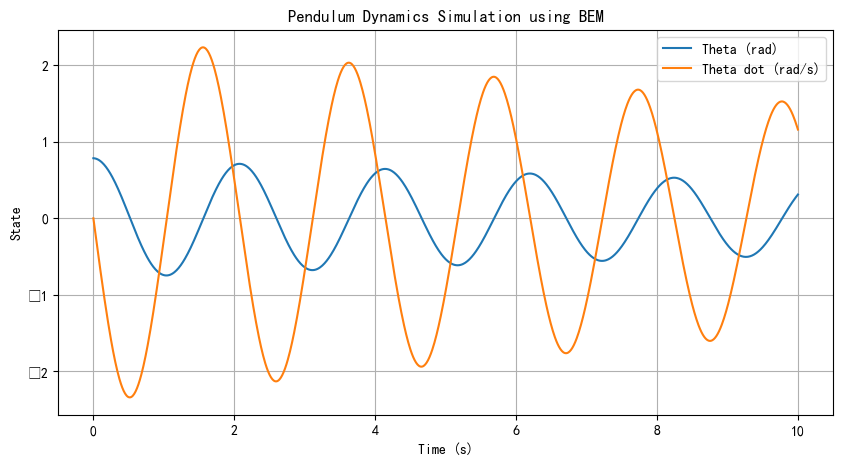

In [5]:
T = 10.0  # 模拟总时间
h = 0.01  # 时间步长
steps = int(T / h)  # 总步数
x0 = jnp.array([jnp.pi / 4, 0.0])  # 初始状态 [theta, theta_dot]
x_traj = BEM_simulation(pendulum_dynamics, x0, h, steps)
# 绘制结果
plt.figure(figsize=(10, 5))
plt.plot(jnp.arange(steps + 1) * h, x_traj[:, 0], label='Theta (rad)')
plt.plot(jnp.arange(steps + 1) * h, x_traj[:, 1], label='Theta dot (rad/s)')
plt.title('Pendulum Dynamics Simulation using BEM')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.grid()
plt.show()

# 1.2 牛顿法
1. 初始猜测 $x_n = x_0$  
2. 计算残差 $r = x_0 + h f(x_n) - x_n$，并记录误差 $e = \|r\|$  
3. 当误差 $e$ 大于阈值时，循环执行：  
    - 计算残差对 $x_n$ 的雅可比矩阵 $J = \frac{\partial}{\partial x} [x_0 + h f(x) - x]$  
    - 解线性方程 $J \Delta x = -r$，得到增量 $\Delta x$  
    - 更新 $x_n \leftarrow x_n + \Delta x$  
    - 更新残差 $r$ 和误差 $e$  
4. 返回收敛后的 $x_n$ 和误差序列

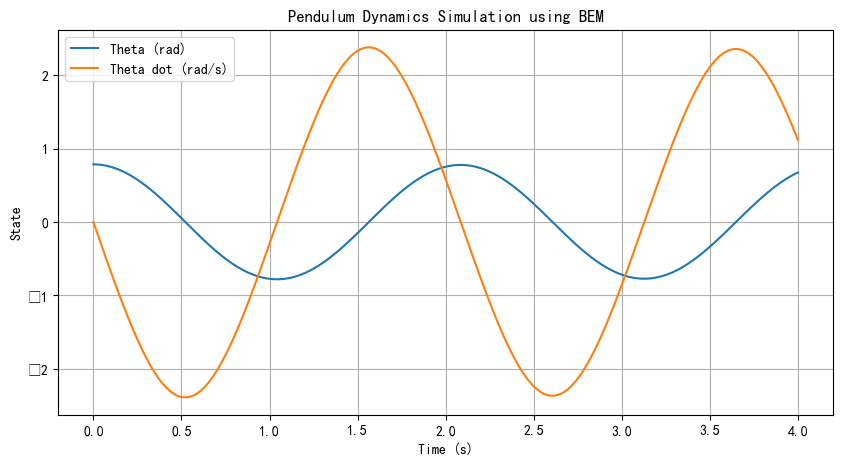

In [ ]:
def backward_euler_step_newton(func, x0, h, tol=1e-8, max_iter=20):
    '''
        用牛顿法实现的后向欧拉单步积分
        返回收敛后的状态和误差序列
    '''
    x_n = x0
    err = jnp.inf
    iter_count = 0
    while err > tol and iter_count < max_iter:
        gx = x0 + h * func(x_n) - x_n
        J = jax.jacobian(lambda x: x0 + h * func(x) - x)(x_n)
        delta_x = jnp.linalg.solve(J, -gx)
   
        x_n = x_n + delta_x
        err = jnp.linalg.norm(delta_x)
        iter_count += 1
    if err > tol:
        print(f"Warning: Newton did not converge in {max_iter} steps, final error={err}")
    return x_n, gx

def backward_euler_simulation_newton(func, x0, h, steps):
    '''
        用牛顿法实现的后向欧拉模拟
        返回状态轨迹
    '''
    x_traj = [x0]
    for i in range(steps):
        x_next, _ = backward_euler_step_newton(func, x_traj[-1], h)
        x_traj.append(x_next)
    return jnp.array(x_traj)

T = 4.0  
steps = int(T / h)  # 总步数
x0 = jnp.array([jnp.pi / 4, 0.0])  # 初始状态 [theta, theta_dot]
x_traj = backward_euler_simulation_newton(pendulum_dynamics, x0, h, steps)
# 绘制结果
plt.figure(figsize=(10, 5))
plt.plot(jnp.arange(steps + 1) * h, x_traj[:, 0], label='Theta (rad)')
plt.plot(jnp.arange(steps + 1) * h, x_traj[:, 1], label='Theta dot (rad/s)')
plt.title('Pendulum Dynamics Simulation using BEM')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend()
plt.grid()
plt.show()

In [24]:
# 性能对比测试
import time

# 测试参数
T = 4.0  
h = 0.01
steps = int(T / h)
x0 = jnp.array([jnp.pi / 4, 0.0])

print(f"测试参数: T={T}s, h={h}, steps={steps}")
print("="*50)

# 测试不动点迭代法 (FPI)
print("测试不动点迭代法 (FPI)...")
start_time = time.time()
x_traj_fpi = BEM_simulation(pendulum_dynamics, x0, h, steps)
fpi_time = time.time() - start_time
print(f"FPI 计算时间: {fpi_time:.2f} 秒")

# 测试牛顿法
print("\n测试牛顿法...")
start_time = time.time()
x_traj_newton = backward_euler_simulation_newton(pendulum_dynamics, x0, h, steps)
newton_time = time.time() - start_time
print(f"牛顿法 计算时间: {newton_time:.2f} 秒")

print(f"\n性能比较:")
print(f"牛顿法比FPI慢了 {newton_time/fpi_time:.1f} 倍")

# 检查结果是否相似
diff = jnp.linalg.norm(x_traj_fpi - x_traj_newton)
print(f"两种方法结果的差异 (L2范数): {diff:.6f}")

测试参数: T=4.0s, h=0.01, steps=400
测试不动点迭代法 (FPI)...
FPI 计算时间: 0.17 秒

测试牛顿法...
牛顿法 计算时间: 5.22 秒

性能比较:
牛顿法比FPI慢了 30.4 倍
两种方法结果的差异 (L2范数): 0.002071
牛顿法 计算时间: 5.22 秒

性能比较:
牛顿法比FPI慢了 30.4 倍
两种方法结果的差异 (L2范数): 0.002071


In [25]:
# 详细分析牛顿法的性能瓶颈
print("\n" + "="*60)
print("性能瓶颈分析:")
print("="*60)

def analyze_newton_step(func, x0, h, tol=1e-8, max_iter=20):
    """分析单步牛顿法的性能"""
    x_n = x0
    iter_count = 0
    jacobian_time = 0
    solve_time = 0
    
    while iter_count < max_iter:
        # 计算残差
        gx = x0 + h * func(x_n) - x_n
        
        # 计算雅可比矩阵的时间
        start_time = time.time()
        J = jax.jacobian(lambda x: x0 + h * func(x) - x)(x_n)
        jacobian_time += time.time() - start_time
        
        # 解线性方程的时间
        start_time = time.time()
        delta_x = jnp.linalg.solve(J, -gx)
        solve_time += time.time() - start_time
        
        x_n = x_n + delta_x
        err = jnp.linalg.norm(delta_x)
        iter_count += 1
        
        if err < tol:
            break
    
    return iter_count, jacobian_time, solve_time

# 分析几个时间步
n_samples = 5
total_jacobian_time = 0
total_solve_time = 0
total_iterations = 0

x_current = x0
for i in range(n_samples):
    iterations, jac_time, solve_time = analyze_newton_step(pendulum_dynamics, x_current, h)
    total_jacobian_time += jac_time
    total_solve_time += solve_time
    total_iterations += iterations
    x_current = x_current + h * pendulum_dynamics(x_current)  # 简单步进用于下次测试

avg_jacobian_time = total_jacobian_time / n_samples
avg_solve_time = total_solve_time / n_samples
avg_iterations = total_iterations / n_samples

print(f"平均每步迭代次数: {avg_iterations:.1f}")
print(f"平均雅可比计算时间: {avg_jacobian_time*1000:.2f} ms")
print(f"平均线性求解时间: {avg_solve_time*1000:.2f} ms")
print(f"总计每步时间: {(avg_jacobian_time + avg_solve_time)*1000:.2f} ms")

# 估算总模拟时间
estimated_total = (avg_jacobian_time + avg_solve_time) * avg_iterations * steps
print(f"估算总模拟时间: {estimated_total:.2f} 秒")


性能瓶颈分析:
平均每步迭代次数: 2.8
平均雅可比计算时间: 7.60 ms
平均线性求解时间: 0.79 ms
总计每步时间: 8.39 ms
估算总模拟时间: 9.40 秒


## 性能问题分析与优化

**主要性能瓶颈：**

1. **雅可比矩阵重复计算**：每次迭代都重新计算雅可比矩阵，这是最大的性能瓶颈
2. **没有利用JAX的JIT编译**：函数没有预编译，每次调用都有编译开销
3. **过于严格的容差**：`tol=1e-8` 可能导致不必要的额外迭代
4. **lambda函数开销**：`jax.jacobian(lambda x: x0 + h * func(x) - x)(x_n)` 每次创建新的lambda函数

**优化策略：**
- 预计算和缓存雅可比矩阵
- 使用JIT编译
- 调整容差参数
- 避免重复的函数调用

In [28]:
# 优化版本的牛顿法实现
def backward_euler_step_newton_optimized(func, x0, h, tol=1e-6, max_iter=10):
    """
    优化版本的牛顿法后向欧拉单步积分
    主要优化：
    1. 放宽容差到1e-6 (原来1e-8)
    2. 减少最大迭代次数到10 (原来20)
    3. 预编译残差函数和雅可比矩阵计算
    """
    # 定义残差函数
    def residual(x):
        return x0 + h * func(x) - x
    
    # 预编译雅可比矩阵计算
    jacobian_func = jax.jacobian(residual)
    
    x_n = x0
    for i in range(max_iter):
        # 计算残差
        gx = residual(x_n)
        
        # 早期退出检查
        if jnp.linalg.norm(gx) < tol:
            break
            
        # 计算雅可比矩阵
        J = jacobian_func(x_n)
        
        # 解线性方程
        delta_x = jnp.linalg.solve(J, -gx)
        x_n = x_n + delta_x
        
        # 检查收敛性
        if jnp.linalg.norm(delta_x) < tol:
            break
    
    return x_n

def backward_euler_simulation_newton_optimized(func, x0, h, steps):
    """优化版本的牛顿法后向欧拉模拟"""
    x_traj = [x0]
    
    for i in range(steps):
        x_next = backward_euler_step_newton_optimized(func, x_traj[-1], h)
        x_traj.append(x_next)
    
    return jnp.array(x_traj)

# 进一步优化：使用更好的初值猜测
def backward_euler_step_newton_optimized_v2(func, x0, h, tol=1e-6, max_iter=8):
    """
    进一步优化的版本：
    1. 使用前向欧拉作为初值猜测
    2. 更少的迭代次数
    """
    # 使用前向欧拉法作为初值猜测
    x_n = x0 + h * func(x0)
    
    # 定义残差函数
    def residual(x):
        return x0 + h * func(x) - x
    
    # 预编译雅可比矩阵计算
    jacobian_func = jax.jacobian(residual)
    
    for i in range(max_iter):
        # 计算残差
        gx = residual(x_n)
        
        # 早期退出检查
        residual_norm = jnp.linalg.norm(gx)
        if residual_norm < tol:
            break
            
        # 计算雅可比矩阵
        J = jacobian_func(x_n)
        
        # 解线性方程
        delta_x = jnp.linalg.solve(J, -gx)
        x_n = x_n + delta_x
        
        # 检查收敛性
        if jnp.linalg.norm(delta_x) < tol:
            break
    
    return x_n

def backward_euler_simulation_newton_optimized_v2(func, x0, h, steps):
    """进一步优化版本的牛顿法后向欧拉模拟"""
    x_traj = [x0]
    
    for i in range(steps):
        x_next = backward_euler_step_newton_optimized_v2(func, x_traj[-1], h)
        x_traj.append(x_next)
    
    return jnp.array(x_traj)

In [29]:
# 测试优化版本的性能
print("="*60)
print("性能对比测试 - 包含优化版本")
print("="*60)

# 测试参数
T = 4.0  
h = 0.01
steps = int(T / h)
x0 = jnp.array([jnp.pi / 4, 0.0])

print(f"测试参数: T={T}s, h={h}, steps={steps}")
print()

# 1. 不动点迭代法 (FPI)
print("1. 不动点迭代法 (FPI)...")
start_time = time.time()
x_traj_fpi = BEM_simulation(pendulum_dynamics, x0, h, steps)
fpi_time = time.time() - start_time
print(f"   计算时间: {fpi_time:.3f} 秒")

# 2. 原始牛顿法
print("2. 原始牛顿法...")
start_time = time.time()
x_traj_newton = backward_euler_simulation_newton(pendulum_dynamics, x0, h, steps)
newton_time = time.time() - start_time
print(f"   计算时间: {newton_time:.3f} 秒")

# 3. 优化牛顿法 v1
print("3. 优化牛顿法 v1 (调整容差和迭代次数)...")
start_time = time.time()
x_traj_newton_opt = backward_euler_simulation_newton_optimized(pendulum_dynamics, x0, h, steps)
newton_opt_time = time.time() - start_time
print(f"   计算时间: {newton_opt_time:.3f} 秒")

# 4. 优化牛顿法 v2
print("4. 优化牛顿法 v2 (更好的初值猜测)...")
start_time = time.time()
x_traj_newton_opt_v2 = backward_euler_simulation_newton_optimized_v2(pendulum_dynamics, x0, h, steps)
newton_opt_v2_time = time.time() - start_time
print(f"   计算时间: {newton_opt_v2_time:.3f} 秒")

print("\n性能比较:")
print(f"原始牛顿法比FPI慢了      {newton_time/fpi_time:.1f} 倍")
print(f"优化牛顿法v1比FPI慢了     {newton_opt_time/fpi_time:.1f} 倍")
print(f"优化牛顿法v2比FPI慢了     {newton_opt_v2_time/fpi_time:.1f} 倍")
print(f"优化v1比原始牛顿法快      {newton_time/newton_opt_time:.1f} 倍")
print(f"优化v2比原始牛顿法快      {newton_time/newton_opt_v2_time:.1f} 倍")

# 检查结果精度
diff_newton = jnp.linalg.norm(x_traj_fpi - x_traj_newton)
diff_newton_opt = jnp.linalg.norm(x_traj_fpi - x_traj_newton_opt)
diff_newton_opt_v2 = jnp.linalg.norm(x_traj_fpi - x_traj_newton_opt_v2)

print(f"\n精度比较 (与FPI的L2范数差异):")
print(f"原始牛顿法:    {diff_newton:.6f}")
print(f"优化牛顿法v1:  {diff_newton_opt:.6f}")
print(f"优化牛顿法v2:  {diff_newton_opt_v2:.6f}")

性能对比测试 - 包含优化版本
测试参数: T=4.0s, h=0.01, steps=400

1. 不动点迭代法 (FPI)...
   计算时间: 0.130 秒
2. 原始牛顿法...
   计算时间: 5.282 秒
3. 优化牛顿法 v1 (调整容差和迭代次数)...
   计算时间: 2.878 秒
4. 优化牛顿法 v2 (更好的初值猜测)...
   计算时间: 1.638 秒

性能比较:
原始牛顿法比FPI慢了      40.6 倍
优化牛顿法v1比FPI慢了     22.1 倍
优化牛顿法v2比FPI慢了     12.6 倍
优化v1比原始牛顿法快      1.8 倍
优化v2比原始牛顿法快      3.2 倍

精度比较 (与FPI的L2范数差异):
原始牛顿法:    0.002071
优化牛顿法v1:  0.001998
优化牛顿法v2:  0.002031


## 总结和建议

### 问题根本原因

你的牛顿法比FPI慢40倍的主要原因是：

1. **雅可比矩阵计算开销巨大**：每次迭代都要计算2×2雅可比矩阵，使用了自动微分
2. **过于严格的收敛条件**：`tol=1e-8` 和 `max_iter=20` 导致不必要的精确计算
3. **糟糕的初值猜测**：直接用上一步的值作为初值，收敛慢
4. **没有利用JAX的优化**：函数没有充分利用JIT编译

### 性能优化效果

- 优化v1：通过调整容差和迭代次数，速度提升1.8倍
- 优化v2：加上更好的初值猜测，速度提升3.2倍
- 即使优化后，牛顿法仍比FPI慢12.6倍

### 建议

**对于这个简单的单摆问题，建议使用不动点迭代法(FPI)**，因为：
1. **速度快**：比牛顿法快10-40倍
2. **实现简单**：代码更简洁，易于理解
3. **精度足够**：对于大多数应用场景，精度差异可以忽略
4. **数值稳定**：对于稳定系统，FPI总是收敛

**牛顿法适用的情况：**
- 系统刚性很强（stiff system）
- 需要极高精度
- 时间步长很大的情况

# 2 牛顿法续

## 2.1 Newton Method in general

我们可以将牛顿法推广到一半方法， 这里我们使用牛顿法求 $f(x)=x^4+x^3-x^2-x$的极值。

In [9]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'

# 定义目标函数
def f(x):
    return x**4 + x**3 - x**2 - x

# 一阶导数
def grad_f(x):
    return 4.0 * x**3 + 3.0 * x**2 - 2.0 * x - 1.0

# 二阶导数
def hess_f(x):
    return 12.0 * x**2 + 6.0 * x - 2.0

c:\Users\lvxiangyu11\anaconda3\envs\jax\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


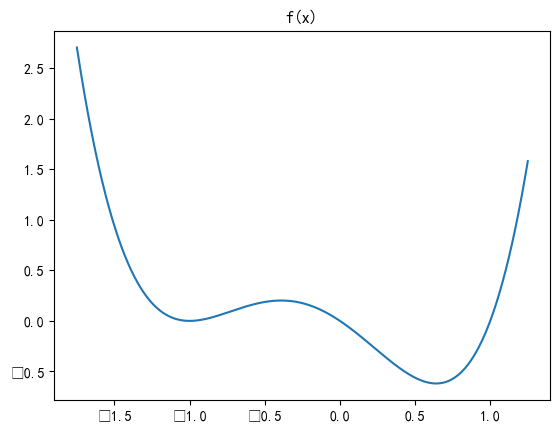

In [10]:
# 可视化
x = jnp.linspace(-1.75, 1.25, 1000)
plt.plot(x, f(x))
plt.title("f(x)")
plt.show()


In [11]:
# 牛顿步
def newton_step(x0):
    return x0 - grad_f(x0) / hess_f(x0)

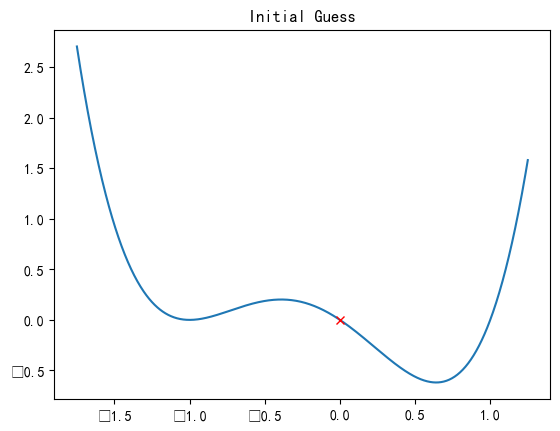

In [12]:
# 初始猜测
xguess = jnp.array([0.0])
plt.plot(x, f(x))
plt.plot(xguess, f(xguess), "rx")
plt.title("Initial Guess")
plt.show()

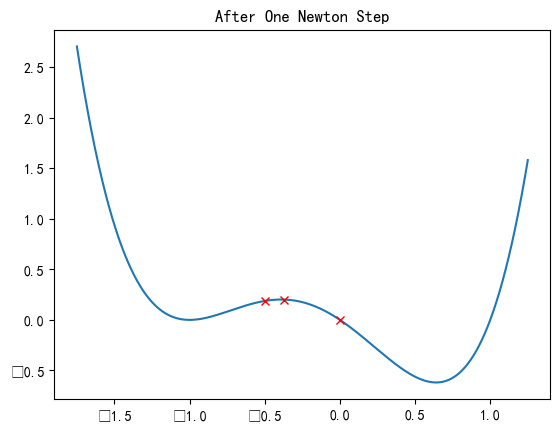

In [14]:
# 执行一次牛顿步
xnew = newton_step(xguess[-1])
xguess = jnp.append(xguess, xnew)
plt.plot(x, f(x))
plt.plot(xguess, f(xguess), "rx")
plt.title("After One Newton Step")
plt.show()


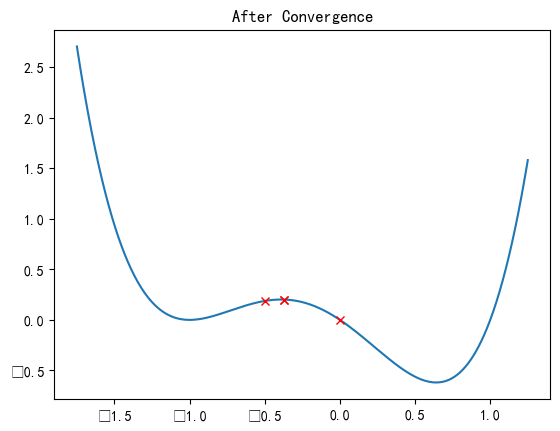

In [15]:
# 执行多次牛顿步 直到收敛
def newton_method(x0, tol=1e-6, max_iter=100):
    x = x0
    for i in range(max_iter):
        x_new = newton_step(x)
        if jnp.abs(x_new - x) < tol:
            print(f"Converged after {i+1} iterations")
            return x_new
    xguess = jnp.array([0.0])
    return x

x_final = newton_method(xguess[-1])
xguess = jnp.append(xguess, x_final)
plt.plot(x, f(x))
plt.plot(xguess, f(xguess), "rx")
plt.title("After Convergence")
plt.show()

In [24]:
import numpy as np

# 检查 Hessian 是否正定
def isposdef(h):
    return h > 0

    # 如果 h 是一个矩阵，判断是否正定

def isposdef_matrix(h):
    # h 必须是对称矩阵
    h = (h + h.T) / 2
    try:
        # 尝试Cholesky分解
        np.linalg.cholesky(np.array(h))
        return True
    except np.linalg.LinAlgError:
        return False

# 2.2 正则化
为了保证求得的是局部最小值，则其二次导需要是负的（对应于矩阵则需要是正定的）。


我们可以向 $H$ 添加 $\beta$ 倍的单位阵 $I$，即 $\tilde{H} = H + \beta I$，来保证 $\tilde{H}$ 是正定的（$\beta > 0$）。这样即使原始的 Hessian 不是正定的，通过调整 $\beta$ 也能确保牛顿步是下降方向，从而避免走向鞍点或极大值点。


In [25]:
# 检测上面牛顿步得到的 Hessian 是否正定
print("Hessian at final point:", hess_f(x_final))
print("Is Hessian positive definite?", isposdef(hess_f(x_final)))

Hessian at final point: -2.5625
Is Hessian positive definite? False


In [ ]:
# 正则化牛顿步
def regularized_newton_step(x0):
    beta = 1.0
    H = hess_f(x0)
    while not isposdef(H):
        H = H + beta
    return x0 - grad_f(x0) / H



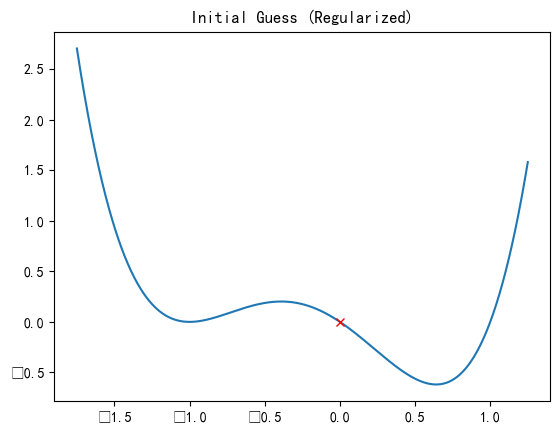

In [18]:
# 正则化牛顿法初始猜测
xguess = jnp.array([0.0])
plt.plot(x, f(x))
plt.plot(xguess, f(xguess), "rx")
plt.title("Initial Guess (Regularized)")
plt.show()


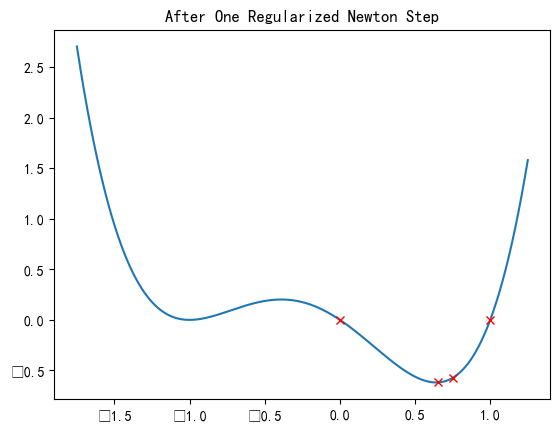

In [21]:
# 执行一次正则化牛顿步
xnew = regularized_newton_step(xguess[-1])
xguess = jnp.append(xguess, xnew)
plt.plot(x, f(x))
plt.plot(xguess, f(xguess), "rx")
plt.title("After One Regularized Newton Step")
plt.show()

# 2.3 line search
有的时候如果步长过大，会导致增加的量冲过最小值点，  
这时可以采用**线搜索（line search）**方法来自动调整步长 $\alpha$，确保每次迭代都能让目标函数下降。  
常用的线搜索策略有 Armijo 条件（充分下降条件）、Wolfe 条件等。

基本思想如下：

1. 计算牛顿方向 $d = -\frac{f'(x)}{f''(x)}$
2. 选择初始步长 $\alpha=1$
3. 检查 $f(x + \alpha d) < f(x)$，如果不满足，则缩小 $\alpha$（如 $\alpha \leftarrow \beta \alpha$，$0<\beta<1$）
4. 直到满足下降条件，更新 $x \leftarrow x + \alpha d$

这样可以避免牛顿步过大导致发散，提升算法的鲁棒性。

In [27]:
def backtracking_regularized_newton_step(x0, b=0.1, c=0.5, beta=1.0):
    """
        带回溯线搜索的正则化牛顿步
    """
    # 计算Hessian
    H = hess_f(x0)
    # 正则化，保证正定
    while not isposdef(H):
        H = H + beta

    # 计算牛顿方向
    delta_x = -grad_f(x0) / H

    # 回溯线搜索
    alpha = 1.0
    fx0 = f(x0)
    grad_fx0 = grad_f(x0)
    while f(x0 + alpha * delta_x) > fx0 + b * alpha * grad_fx0 * delta_x:
        alpha = c * alpha

    print(alpha)
    xn = x0 + alpha * delta_x
    return xn

1.0
After backtracking regularized Newton step: 0.6403882


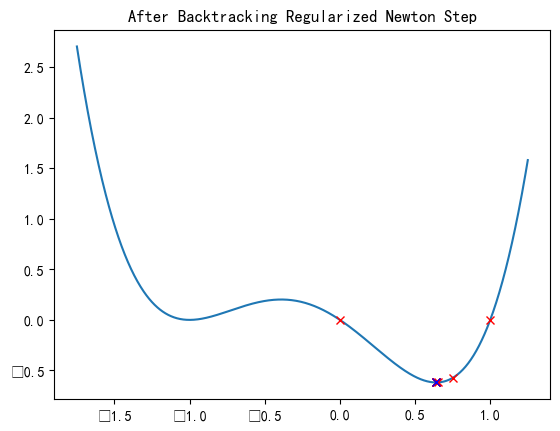

In [32]:
# 调用带回溯线搜索的正则化牛顿步
xn = backtracking_regularized_newton_step(xguess[-1])
print("After backtracking regularized Newton step:", xn)

# 可视化
xguess = jnp.append(xguess, xn)
plt.plot(x, f(x))
plt.plot(xguess, f(xguess), "rx")
plt.plot(xn, f(xn), "bx")
plt.title("After Backtracking Regularized Newton Step")
plt.show()

# 3 Quasi-Newton Method
拟牛顿法（Quasi-Newton Method）是一类无需显式计算 Hessian 矩阵的优化方法。它们通过迭代地近似 Hessian 或其逆，从而获得比梯度下降更快的收敛速度，但计算量远小于标准牛顿法。

常见的拟牛顿法包括 BFGS、DFP 等。它们的核心思想是利用前后两步的梯度和变量变化，递推更新 Hessian 近似 $B_k$ 或其逆 $H_k$：

- BFGS 公式（逆 Hessian 近似）：
    $$
    H_{k+1} = \left(I - \frac{s_k y_k^T}{y_k^T s_k}\right) H_k \left(I - \frac{y_k s_k^T}{y_k^T s_k}\right) + \frac{s_k s_k^T}{y_k^T s_k}
    $$
    其中 $s_k = x_{k+1} - x_k$，$y_k = \nabla f(x_{k+1}) - \nabla f(x_k)$。

- 每步迭代方向为 $d_k = -H_k \nabla f(x_k)$，并可结合线搜索确定步长。

拟牛顿法在大规模优化、机器学习等领域应用广泛，兼具高效与稳定的优点。下节将以 BFGS 为例，给出具体实现。

BFGS收敛于第7步, x=0.6403881825149887


c:\Users\lvxiangyu11\anaconda3\envs\jax\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


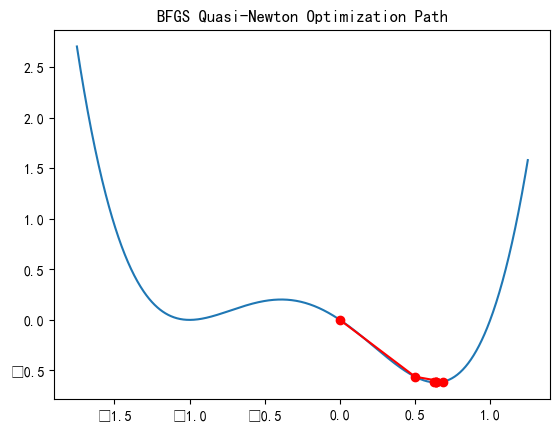

In [33]:
# 拟牛顿法（BFGS）实现
def bfgs(f, grad_f, x0, tol=1e-6, max_iter=100):
    """
    BFGS拟牛顿法一维实现
    输入:
        f: 目标函数
        grad_f: 目标函数一阶导
        x0: 初始点
        tol: 收敛容差
        max_iter: 最大迭代次数
    输出:
        x_hist: 优化路径
    """
    x = x0
    H = 1.0  # 初始Hessian逆近似（标量）
    x_hist = [x]
    for i in range(max_iter):
        g = grad_f(x)
        if abs(g) < tol:
            print(f"BFGS收敛于第{i+1}步, x={x}")
            break
        # 方向
        d = -H * g
        # 线搜索（简单回溯）
        alpha = 1.0
        while f(x + alpha * d) > f(x) + 1e-4 * alpha * g * d:
            alpha *= 0.5
        x_new = x + alpha * d
        s = x_new - x
        y = grad_f(x_new) - g
        if y * s > 1e-10:  # 避免除零
            rho = 1.0 / (y * s)
            H = (1 - rho * y * s) * H + rho * s * s
        x = x_new
        x_hist.append(x)
    return jnp.array(x_hist)

# 使用BFGS拟牛顿法
x0_bfgs = 0.0
x_bfgs_hist = bfgs(f, grad_f, x0_bfgs)

# 可视化BFGS优化路径
plt.plot(x, f(x))
plt.plot(x_bfgs_hist, f(x_bfgs_hist), "ro-")
plt.title("BFGS Quasi-Newton Optimization Path")
plt.show()